<a href="https://colab.research.google.com/github/xCocco0/alzheimer-recognition/blob/relabeled/alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's Disease AI
The aim of this project is the developement and evaluation of an AI to classify patients affected by various stages of dementia and/or Alzheimer's Disease. We will focus on data inspection and analysis, then proceed on the realization of an AI through the use of machine learning methods.

## What is dementia?
> *Dementia manifests as a set of related symptoms, which usually surfaces when the brain is damaged by injury or disease.[2] The symptoms involve progressive impairments in memory, thinking, and behavior, which negatively impacts a person's ability to function and carry out everyday activities. Aside from memory impairment and a disruption in thought patterns, the most common symptoms include emotional problems, difficulties with language, and decreased motivation.[...] A diagnosis of dementia requires a change from a person's usual mental functioning and a greater cognitive decline than what is caused by normal aging [...] however, the most common cause is Alzheimer's disease, a neurodegenerative disorder [...]*

> *The part of the brain most affected by Alzheimer's is the hippocampus. Other parts that show atrophy (shrinking) include the temporal and parietal lobes [...] Little is known about the events that occur during and that actually cause Alzheimer's disease,[...] it is known that one of the first aspects of the disease is a dysfunction in the gene that produces amyloid* [[10]](https://en.wikipedia.org/wiki/Dementia)

## The data
All the data were provided by OASIS[[1]](https://www.oasis-brains.org/) (Open Access Series of Imaging Studies), in particular from their third and biggest study OASIS-3.
> _OASIS-3 is a retrospective compilation of data for >1000 participants that were collected across several ongoing projects through the WUSTL Knight ADRC over the course of 30 years. Participants include 609 cognitively normal adults and 489 individuals at various stages of cognitive decline ranging in age from 42-95yrs. All participants were assigned a new random identifier and all dates were removed and normalized to reflect days from entry into study. The dataset contains over 2000 MR sessions which include T1w, T2w, FLAIR, ASL, SWI, time of flight, resting-state BOLD, and DTI sequences. Many of the MR sessions are accompanied by volumetric segmentation files produced through Freesurfer processing. PET imaging from 3 different tracers, PIB, AV45, and FDG, totaling over 1500 raw imaging scans and the accompanying post-processed files from the Pet Unified Pipeline (PUP) are also available in OASIS-3._

Among these information, demographical data and MRI scans reports were of particular relevance.

### Setup up the Python enviroment
This contains imports and constants we will use later.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

def select(df_, category):
  if category == 0:
    return df_.query("dementia == 0 and alzheimer == 0")
  elif category == 1:
    return df_.query("dementia == 1 and alzheimer == 0")
  elif category == 2:
    return df_.query("alzheimer == 1")

index2color = {0:'#64C4E480', 1:'#FFC030A0', 2:'#FF8020A0'}
index2label = {0:'Non demented', 1:'Dementia', 2:'Alzheimer'}

### Overview
The data below was extracted and calculated based on the OASIS-3 Dataset.
- **ID**: Unique identifier for the patients
- **Sex**: Where 1 stands for male, and 0 for female
- **Age**: Age in years
- **Height**: Measured in mm, has an accuracy of &#177;13mm
- **Weight**: Measured in kg
- **Education**: Total years of education
- **Hand**: Where 1 stands for right handed, 0 for left handed and 2 for ambidextrous
- **mmse**: MMSE[[3]](https://en.wikipedia.org/w/index.php?title=Mini%E2%80%93Mental_State_Examination&oldid=1076211630) (Mini Mental State Examination) score from 0 to 30
- **cdr**: Clinical Dementia Rating, measures the severity of dementia: 0   none, 0.5   very mild, 1    mild, 2 moderate, 3 severe
- **dx1**: Dementia related clinical diagnosis
- **dx2-5**: Other conditions the patient is affected by
- **eTIV**: Estimated Total Intracranical Volume in mm<sup>3</sup>[[2]](https://www.oasis-brains.org/files/OASIS-3_Imaging_Data_Dictionary_v1.5.pdf)
- **brainVol**: Brain valume in mm<sup>3</sup>
- **ventricleVol**: Sum of the volumes of left lateral ventricle, right lateral ventricle, 3rd ventricle, 4th ventricle and 5th ventricle in mm<sup>3</sup>
- **hcVol**: Total hippocampus volume in mm<sup>3</sup>

In addition, we managed to compute the following additional features:
- **nWBV**: brainVol/eTIV ratio
- **ventricleRatio**: ventricleVol/eTIV ratio
- **hcRatio**: hcVol/eTIV ratio
- **dementia**: either 1 or 0, based on dx1
- **alzheimer**: either 1 or 0, based on dx1

<sub>Note: brain volumes were calculated by OASIS using FreeSurfer[[4]](https://surfer.nmr.mgh.harvard.edu/) software to analyse MRI scans</sub>

In [ ]:
try:
  df = pd.read_csv("/content/data/alzheimer.csv")
except FileNotFoundError:
  print("Copying data from github")
  !git clone https://gist.github.com/31f6b616f45377742c185a541dc056ac.git /content/data
  try:
    df = pd.read_csv("/content/data/alzheimer.csv")
  except FileNotFoundError:
    !rm -R /content/data
    !git clone https://gist.github.com/31f6b616f45377742c185a541dc056ac.git /content/data
    try:
      df = pd.read_csv("/content/data/alzheimer.csv")
    except FileNotFoundError:
      print("\n\n","Error:\nCouldn't fetch data. Please manually upload table to /content/data/alzheimer.csv","\n\n")

df

,id,sex,age,height,weight,education,hand,mmse,cdr,dementia,...,dx3,dx4,dx5,eTIV,brainVol,nWBV,ventricleVol,ventricleRatio,hcVol,hcRatio
0,OAS30001,0,65,1626,76,12,1,30,0.0,0,...,NaN,NaN,NaN,119.699,75.075,0.62719,1.55828,0.01302,0.70638,0.00590
1,OAS30002,1,67,1600,71,18,1,29,0.0,0,...,NaN,NaN,NaN,172.725,104.277,0.60372,4.14604,0.02400,0.88603,0.00513
2,OAS30003,0,58,1702,73,16,1,30,0.0,0,...,NaN,NaN,NaN,142.700,91.455,0.64089,1.74855,0.01225,0.82226,0.00576
3,OAS30004,0,55,1626,86,17,0,30,0.0,0,...,NaN,NaN,NaN,145.447,92.643,0.63696,2.21351,0.01522,0.82862,0.00570
4,OAS30005,0,48,1575,76,16,1,29,0.0,0,...,NaN,NaN,NaN,153.993,99.028,0.64307,0.98691,0.00641,0.87477,0.00568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,OAS31165,1,55,1753,83,12,1,25,0.0,0,...,NaN,NaN,NaN,140.838,90.968,0.64591,1.12186,0.00797,0.77437,0.00550
889,OAS31166,0,59,1651,76,13,0,26,0.0,0,...,Active Hypothyroidism,NaN,NaN,158.512,102.819,0.64865,1.54605,0.00975,0.89208,0.00563
890,OAS31167,1,51,1778,94,22,1,30,0.0,0,...,NaN,NaN,NaN,152.785,96.859,0.63396,1.28720,0.00842,0.88671,0.00580
891,OAS31168,1,65,1829,80,16,1,30,0.0,0,...,NaN,NaN,NaN,162.170,95.877,0.59122,3.29980,0.02035,0.73732,0.00455


Below are a few general statistics about data. Among these, correlation between CDR/MMSE and other features will play a critical role in the creation of the AI. This is what we will investigate in the following sections.

In [85]:
print("--- Statistics ---\n",
      df.describe())

print("\n--- Correlation ---\n")
df[["mmse",'cdr','age','weight','height','eTIV','brainVol','nWBV','ventricleVol','ventricleRatio','hcVol','hcRatio']].corr()

--- Statistics ---
               sex         age       height      weight   education  \
count  893.000000  893.000000   893.000000  893.000000  893.000000   
mean     0.456887   68.653975  1675.709966   77.471445   15.614782   
std      0.498417    8.858256    97.005027   17.042696    2.766205   
min      0.000000   42.000000  1295.000000   37.000000    0.000000   
25%      0.000000   64.000000  1600.000000   65.000000   13.000000   
50%      0.000000   69.000000  1676.000000   76.000000   16.000000   
75%      1.000000   74.000000  1753.000000   87.000000   18.000000   
max      1.000000   94.000000  2007.000000  148.000000   24.000000   

             hand        mmse         cdr    dementia   alzheimer        eTIV  \
count  893.000000  893.000000  893.000000  893.000000  893.000000  893.000000   
mean     0.931691   27.638298    0.221725    0.238522    0.208287  150.554634   
std      0.322604    3.579991    0.396309    0.426419    0.406310   18.464949   
min      0.000000    4.00

,mmse,cdr,age,weight,height,eTIV,brainVol,nWBV,ventricleVol,ventricleRatio,hcVol,hcRatio
mmse,1.000000,-0.795606,-0.291781,0.112163,0.067632,-0.080607,0.218471,0.366115,-0.283968,-0.309052,0.481823,0.459354
cdr,-0.795606,1.000000,0.280224,-0.130354,-0.051822,0.126096,-0.171929,-0.359311,0.325886,0.340021,-0.505889,-0.497787
age,-0.291781,0.280224,1.000000,-0.156481,-0.096301,0.160825,-0.299818,-0.571886,0.466177,0.502588,-0.508880,-0.535751
weight,0.112163,-0.130354,-0.156481,1.000000,0.546525,0.254602,0.320286,0.087500,0.015987,-0.050031,0.237414,0.057149
height,0.067632,-0.051822,-0.096301,0.546525,1.000000,0.507035,0.473231,-0.034870,0.137838,0.022441,0.201403,-0.124105
eTIV,-0.080607,0.126096,0.160825,0.254602,0.507035,1.000000,0.680253,-0.412495,0.569029,0.408275,0.103443,-0.522726
brainVol,0.218471,-0.171929,-0.299818,0.320286,0.473231,0.680253,1.000000,0.377495,0.009517,-0.153958,0.556763,0.063804
nWBV,0.366115,-0.359311,-0.571886,0.087500,-0.034870,-0.412495,0.377495,1.000000,-0.665161,-0.676179,0.548301,0.743378
ventricleVol,-0.283968,0.325886,0.466177,0.015987,0.137838,0.569029,0.009517,-0.665161,1.000000,0.974016,-0.412544,-0.674759
ventricleRatio,-0.309052,0.340021,0.502588,-0.050031,0.022441,0.408275,-0.153958,-0.676179,0.974016,1.000000,-0.498316,-0.660660


### Visualization

#### Distribution plots
The following violin plots will show how the values are distributed in the dataset.

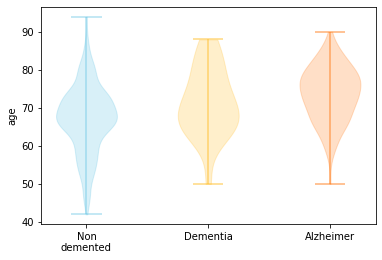

In [86]:
def violin_plot(feature):
  fig, ax = plt.subplots()

  index = 0
  for i in range(3):
    parts = ax.violinplot([
                select(df,i)[feature].to_numpy(dtype = float),
                ], [index+1])

    parts['bodies'][0].set_color(index2color[index])
    parts['cbars'].set_color(index2color[index])
    parts['cmins'].set_color(index2color[index])
    parts['cmaxes'].set_color(index2color[index])
    parts['bodies'][0].set_alpha(0.25)
    index += 1

  ax.set_xticks([1,2,3])
  ax.set_xticklabels(['Non\ndemented', 'Dementia', 'Alzheimer'])
  ax.set_ylabel(feature)
  plt.show()

violin_plot("age")

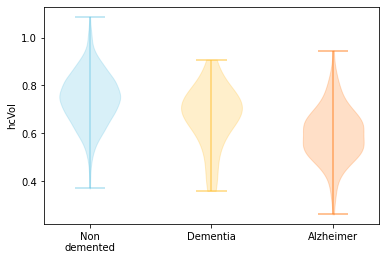

In [ ]:
violin_plot("hcVol")

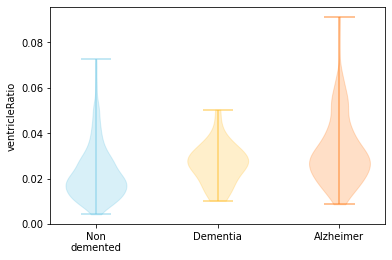

In [88]:
#@title Customise your plot { run: "auto", display-mode: "form" }
feature = "ventricleRatio" #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]

violin_plot(feature)

#### Correlation plots
These are scatter plots that show the relationship between features, for demented or AD affected patients

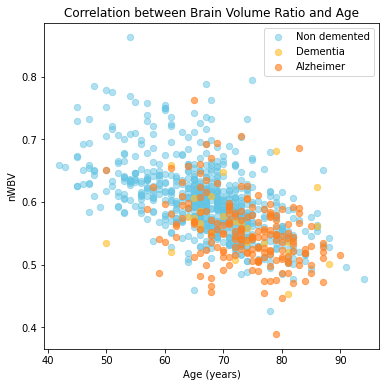

In [89]:
def corr_plot(x,y,title=None,labelx=None,labely=None,dotsize=40):
  if title == None: title = f"Correlation between {x}, {y}"
  if labelx == None: labelx = x
  if labely == None: labely = y;
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(3):
    ax.scatter(select(df,i)[x],
              select(df,i)[y],
              c = index2color[i],
              label = index2label[i], s = dotsize)

  ax.legend()
  ax.set_title(title)
  plt.xlabel(labelx)
  plt.ylabel(labely)
  plt.show()
  
corr_plot('age','nWBV',
          "Correlation between Brain Volume Ratio and Age",'Age (years)','nWBV')

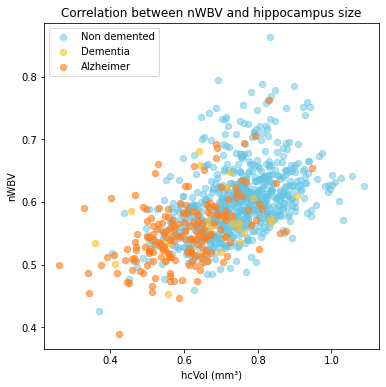

In [90]:
corr_plot('hcVol','nWBV',
          "Correlation between nWBV and hippocampus size",'hcVol (mm\u00B3)','nWBV')

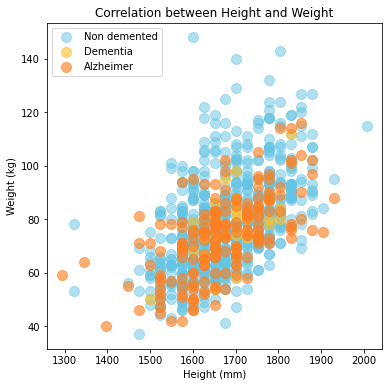

In [91]:
corr_plot('height','weight',
          'Correlation between Height and Weight','Height (mm)','Weight (kg)',100)

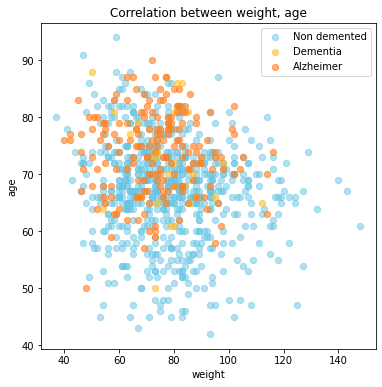

In [92]:
#@title Customise your plot { display-mode: "form" }
x = "weight" #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]
y = "age" #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]

corr_plot(x,y)

From these graphs we can conclude that nWBV and hippocampus size have a strong relationship with dementia, while height doesn't.

#### Frequency plots

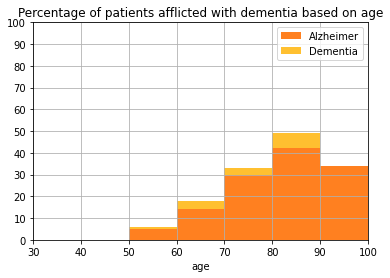

In [93]:
def hist_plot(label, delta, numbars, xmin = 0, xmax = None, df = df):
  if xmax == None:
    xmax = delta*numbars
  hist = np.zeros((numbars,4))
  hist_labels = np.arange(delta/2,delta*(numbars+1/2),delta)

  for index, row in df.iterrows():
    groupindex = int(row[label]/delta)
    if groupindex < numbars:
      if row["alzheimer"] == 1:
        hist[groupindex, 3] += 1
      elif row["dementia"] == 1:
        hist[groupindex, 2] += 1
      else:
        hist[groupindex, 1] += 1
      hist[groupindex, 0] += 1
  #print(hist)
  for row in hist:
    for i in range(1,4):
      if row[0] == 0:
        row[i] = 0
      else:
        row[i] = np.ceil(100 * row[i] / row[0])
  #print(hist)

  fig, ax = plt.subplots()
  ax.bar(hist_labels, hist[:,3], width = delta, color = '#FF8020', label = "Alzheimer")
  ax.bar(hist_labels, hist[:,2], width = delta, bottom = hist[:,3], color = '#FFC030', label = "Dementia")
  #ax.bar(hist_labels, hist[:,1], width = delta, bottom = hist[:,3]+hist[:,2], color = "#64C4E4")

  ax.set_title(f"Percentage of patients afflicted with dementia based on {label}")
  ax.set_ylim(0,100)
  ax.set_xlim(xmin,xmax)
  ax.set_xticks(np.arange(xmin,min(xmax,delta*numbars)+delta/2,delta))
  ax.set_yticks(range(0,101,10))
  ax.grid()
  ax.set_xlabel(label)
  ax.legend()
  plt.show()

hist_plot("age", 10, 10, xmin = 30)

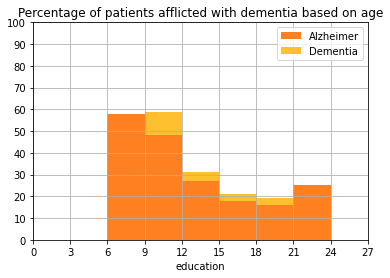

In [94]:
hist_plot("education", 3, 9, xmax = 27)

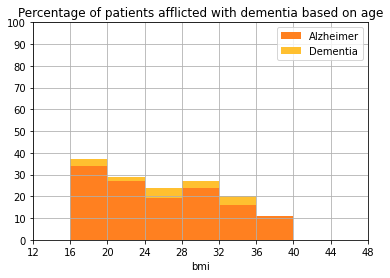

In [95]:
dfbmi = df.loc[:,["alzheimer","dementia"]]
dfbmi["bmi"] = (1000000*df["weight"])/(df["height"]**2)

hist_plot("bmi", 4, 20, xmin = 12, xmax = 48, df = dfbmi)

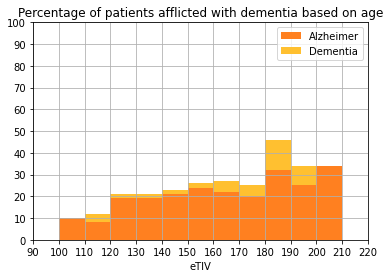

In [96]:
#@title Customise your plot { display-mode: "form" }
label = 'eTIV' #@param ["age", "height", "weight", "eTIV", "brainVol", "nWBV", "ventricleVol", "ventricleRatio", "hcVol", "hcRatio"]
delta =  10#@param {type:"number"}
numbars =  22#@param {type:"integer"}
xmin =  90#@param {type:"integer"}
xmax = None #@param {type:"raw"}

hist_plot(label, delta, numbars, xmin = xmin, xmax = xmax)


From frequency plots we notice that, as expected, dementia is more common in older subjects. On the other hand, education years also seemed to be related to dementia. In facts, MMSE treshold for a diagnosis is often calculated upon age and education years.

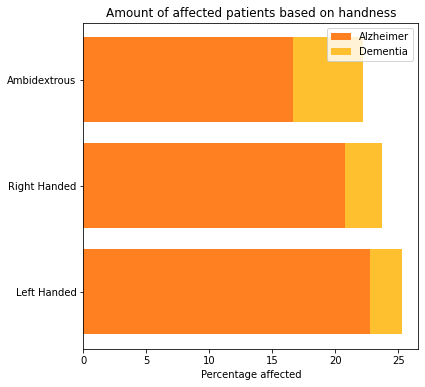

In [97]:
fig, ax = plt.subplots(figsize=(6,6))
bars = np.empty((3,3))

for i in range(0,3):
  for j in range(0,3):
    bars[i,j] = select(df,i).query("hand == @j").loc[:,"id"].count()
#print(handness)
for i in range(0,3):
  bars[:,i] /= np.sum(bars[:,i])
bars = (bars*100)
#print(bars)'#FF8020' '#FFC030'
ax.barh([1,2,3], bars[2,:], color = "#FF8020", label = "Alzheimer")
ax.barh([1,2,3], bars[1,:], left = bars[2,:], color = "#FFC030", label = "Dementia")
#ax.barh([1,2,3], bars[0,:], left = bars[2,:]+bars[1,:], color = "#64C4E480", label = "Non Demented")
ax.set_yticks([1,2,3])
ax.set_yticklabels(['Left Handed','Right Handed','Ambidextrous'])
ax.set_xlabel("Percentage affected")
ax.set_title("Amount of affected patients based on handness")
ax.legend()
plt.show()

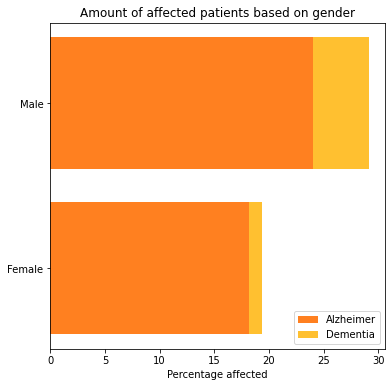

In [98]:
fig, ax = plt.subplots(figsize=(6,6))
bars = np.empty((3,2))

for i in range(0,3):
  for j in range(0,2):
    bars[i,j] = select(df,i).query("sex == @j").loc[:,"id"].count()
#print(bars)
for i in range(0,2):
  bars[:,i] /= np.sum(bars[:,i])
bars = (bars*100)
#print(bars)
ax.barh([1,2], bars[2,:], color = "#FF8020", label = "Alzheimer")
ax.barh([1,2], bars[1,:], left = bars[2,:], color = "#FFC030", label = "Dementia")
#ax.barh([1,2], bars[0,:], left = bars[2,:]+bars[1,:], color = "#64C4E480", label = "Non Demented")
ax.set_yticks([1,2])
ax.set_yticklabels(['Female','Male'])
ax.set_xlabel("Percentage affected")
ax.set_title("Amount of affected patients based on gender")
ax.legend()
plt.show()

It is remarkable that dementia is more frequent in males, and left handed patients (read further [[6]](https://jamanetwork.com/journals/jamaneurology/fullarticle/775393)).

---
## Learning
We can now proceed building the model of the AI.\
We begin defining the input and ouput of the predictor:

$\begin{bmatrix} 
age  \\
education \\
hand \\
eTIV  \\
brainVol  \\
ventricleVol  \\
hcVol
\end{bmatrix}\Longrightarrow
\begin{bmatrix}Alzheimer \end{bmatrix}$

It takes in a few demographic significant features and brain volumes (leaving out ratios to avoid redundancy). The outcome will be a boolean value that represents whether a patient is affected by AD (1) or not (0).


### Accuracy metrics definition

In order to evaluate the quality of the results we will arrange the predictions in a matrix (*confusion matrix*) as such:

$C=\begin{bmatrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{bmatrix},$

where $C_{ij}$ is the sum of all the istances that were originally $i$ and predicted as $j$.

Clearly, we want these values to be larger along the diagonal and near 0 elsewhere. As this result will almost impossible to achieve, we will define less strict metrics that will associate a score between 0 and 1 to the results, where 1 means perfect.

- **Accuracy score**:

  Based on the amount of correct prediction divided by the number of all predictions made

  $score = \frac{1}{N}\sum_{i=1}^{2}C_{ii}$, <sub>where $N$ is the sum of all $C_{ij}$</sub>

- **Weighted score**:

  A variant of the accuracy score, where predictions are weighted based on a given matrix $S$. We will prefer this over accuracy score because
  - it takes into account the large amount of healthy patients versus demented ones,
  - it helps adjusting the sensibility of the predictions: as you can see below, $S_{12}\lt S_{21}$ because flagging AD patients as healthy is better than flagging healthy patients as AD affected.

  $score = \frac{\sum_{i,j\le 2}^{}S_{ij}C_{ij}}{\sum_{i\le 2}^{}S_{ii}C_{ii}}$, where we have chosen $S=\begin{bmatrix}
  50 & 0\\
  20 & 100
  \end{bmatrix}$

- **Reliability score**:

  This is similar to weighted score, but does not depend upon $C_{11}$

  $score = remapfun\bigg(\frac{C_{22}}{C_{12}}w+\frac{C_{22}}{C_{21}}(1-w)\bigg)$, $remapfun(x) = 1-\frac{\alpha}{\alpha+(\frac{x}{\beta})^{2}}$

  where $remapfun()$ may be any function that remap $\left[ 0,\infty  \right)\to \left[ 0,1 \right]$

In [ ]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.neighbors
import sklearn.svm
import sklearn.tree
import sklearn.metrics
import sklearn.preprocessing
import sklearn.calibration

score_matrix = np.array(
    [[ 50,  0],
     [ 20,100]]
)
#print(score_matrix)

def score_weight(y_,y_pred_):
  def norm(x): 
    return int(max(x, 0))
  n = len(y_)
  sc = 0
  for i in range(n):
    #print(norm(y_[i]),"|",norm(y_pred_[i]))
    sc += score_matrix[norm(y_[i]),norm(y_pred_[i])]
  return sc

def score_reliability(y_,y_pred_):
  alpha = 1
  beta = 0.75
  weight = 0.6
  def remapfun(x):
    return 1-alpha/((x/beta)+alpha)
  
  conf = sklearn.metrics.confusion_matrix(y_,y_pred_)
          #predicted demented that were really demented
  return remapfun(((conf[1,1]/conf[0,1]) if conf[0,1] != 0 else 1)*(weight) \
      + ((conf[1,1]/conf[1,0]) if conf[1,0] != 0 else 1)*(1-weight))
          #demented that were predicted as demented

scorer_weight = sklearn.metrics.make_scorer(score_weight)
scorer_reliability = sklearn.metrics.make_scorer(score_reliability)

### Building the model
for clf in clflist:
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  # print(y_pred)
  # print(y_test)
  print(clf, "\n")
  print(sklearn.metrics.confusion_matrix(y_test,y_pred))
  print("Hit ratio:\t\t", sklearn.metrics.accuracy_score(y_test,y_pred))
  print("Reliability score:\t", score_reliability(y_test,y_pred))
  print("Weighted score:\t\t", score_weight(y_test,y_pred)/(score_weight(y_test,y_test)))
  print("--------------------------------------------------------------------------")

We may observe the following results:
- SGD classifier is instable as every training yields different results, it also often tricks itself into thinking that patients are all healthy (as this give a good accuracy score)
- Decision tree classifier does not fit this kind of classification
- SVC and Logistic Regression are acceptable.

The best overall is Logistic Regression: it takes a great advantage from the scoring functions, while being simple and efficient.

The following is a list of patients that had received a bad diagnosis from this last classificator.

In [102]:
# 0 id        8  cdr       16 brainVol 
# 1 sex       9 dementia   17 nWBV 
# 2 age       10 dx1       18 ventricleVol 
# 3 height    11 dx2       19 ventricleRatio 
# 4 weight    12 dx3       20 hcVol 
# 5 education 13 dx4       21 hcRatio
# 6 hand      14 dx5 
# 7 mmse      15 eTIV

def printinfo(row_):
    print("[ Patient:",row_[0], "] Predicted:", y_pred[i], "- was:", y_test[i])
    #print(row_[[1,2,3,4,5,6,15,17,18,20]])
    print(f"Sex: {row_[1]}\t\tEducation: {row_[5]}\teTIV: {row_[15]}")
    print(f"Age: {row_[2]}\t\tHand: {row_[6]}\t\tnWBV: {row_[17]}")
    print(f"Height: {row_[3]}\tMMSE: {row_[7]}\tventricleRatio: {row_[19]}")
    print(f"Weight: {row_[4]}\tCDR: {row_[8]}\thcVol: {row_[20]}")
    print("Diagnosis:",row_[10])
    print("Other:", "  ".join(row_[11:15]))
print("Overstimates")
print("---------------------------------------------------------------------------------------------------------------")
for i in range(len(y_pred)):
  if(y_test[i] < y_pred[i]):
    row = np.ravel(X_test_all.iloc[[i]].fillna('').to_numpy(dtype = str))
    printinfo(row)
    print("---------------------------------------------------------------------------------------------------------------")
print("\nUnderstimates")
print("---------------------------------------------------------------------------------------------------------------")
for i in range(len(y_pred)):
  if(y_test[i] > y_pred[i]):
    row = np.ravel(X_test_all.iloc[[i]].fillna('').to_numpy(dtype = str))
    printinfo(row)
    print("---------------------------------------------------------------------------------------------------------------")

Overstimates
---------------------------------------------------------------------------------------------------------------
[ Patient: OAS30339 ] Predicted: 1 - was: 0
Sex: 1		Education: 16	eTIV: 175.941
Age: 73		Hand: 1		nWBV: 0.54545
Height: 1778	MMSE: 29	ventricleRatio: 0.02135
Weight: 73	CDR: 0.0	hcVol: 0.65161
Diagnosis: Cognitively normal
Other: Active Other neurol/med diagnoses  Oth potentially transmissible dis    
---------------------------------------------------------------------------------------------------------------
[ Patient: OAS31074 ] Predicted: 1 - was: 0
Sex: 1		Education: 14	eTIV: 179.959
Age: 71		Hand: 1		nWBV: 0.55924
Height: 1753	MMSE: 29	ventricleRatio: 0.0351
Weight: 80	CDR: 0.5	hcVol: 0.5878
Diagnosis: uncertain dementia
Other: Remote Mood disorder  Active Med-induced Cog Dys    
---------------------------------------------------------------------------------------------------------------
[ Patient: OAS30087 ] Predicted: 1 - was: 0
Sex: 1		Education: 8	eT

### Neural networks
...

---
## References
1. *T. Benzinger, D. Marcus, J. Morris* **OASIS-3**. NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly: https://doi.org/10.1101/2019.12.13.19014902
2. OASIS-3 data dictionary: https://www.oasis-brains.org/files/OASIS-3_Imaging_Data_Dictionary_v1.5.pdf
3. *Wikipedia contributors.* (2022, March 9). **Mini–Mental State Examination.** In Wikipedia, The Free Encyclopedia: https://en.wikipedia.org/w/index.php?title=Mini%E2%80%93Mental_State_Examination&oldid=1076211630
4. *Athinoula A. Martinos Center for Biomedical Imaging.* **FreeSurfer sofware**: https://surfer.nmr.mgh.harvard.edu/
5. *Jennifer L. Whitwell, William R. Crum, Hilary C. Watt and Nick C. Fox.* **Normalization of Cerebral Volumes by Use of Intracranial Volume**: Implications for Longitudinal Quantitative MR Imaging: http://www.ajnr.org/content/22/8/1483
6. *Doody RS, Vacca JL, Massman PJ, Liao T.* **The Influence of Handedness on the Clinical Presentation and Neuropsychology of Alzheimer Disease**. Arch Neurol. 1999;56(9):1133–1137. doi:10.1001/archneur.56.9.1133: https://jamanetwork.com/journals/jamaneurology/fullarticle/775393
7. *Keith A. Johnson, Nick C. Fox, Reisa A. Sperling and William E. Klunk.* **Brain Imaging in Alzheimer Disease**: http://perspectivesinmedicine.cshlp.org/content/2/4/a006213.long
8. *Apostolova LG.* **Alzheimer Disease. Continuum (Minneap Minn).** 2016;22(2 Dementia):419-434. doi:10.1212/CON.0000000000000307: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5390933/
9. *Ridha, B.H., Anderson, V.M., Barnes, J. et al.* **Volumetric MRI and cognitive measures in Alzheimer disease**. J Neurol 255, 567–574 (2008): https://doi.org/10.1007/s00415-008-0750-9
10. *Wikipedia contributors.* (2022, June 5). **Dementia.** In Wikipedia, The Free Encyclopedia: https://en.wikipedia.org/w/index.php?title=Dementia&oldid=1091715242

---
<sub>Copyright &copy; 2022 Francesco Aiello, Salvatore Attanasio</sub>